In [1]:
import numpy as np
import scipy.stats
import scipy
import logging as logger

In [2]:
class JacksCarRentalEnvironment(object):

    MAX_CAPACITY = 20
    TRANSFER_COST = 2
    REQUEST_RATE = [3, 4]
    RETURN_RATE = [3, 2]
    RENTAL_INCOME = 10
    
    def __init(self):
        self = self.reset()

    def step(self, action):
        done = False
        reward = 0
        info = ''

        if(np.min(observation) <= 0):
            done = True
            info = 'No cars!'
        
        if(not done):
            cars_requested_1 = np.random.poisson(REQUEST_RATE[0])
            cars_requested_2 = np.random.poisson(REQUEST_RATE[1])
            observation[0] = observation[0] - cars_requested_1
            observation[1] = observation[1] - cars_requested_2

        if(np.min(observation) <= 0 and not done):
            done = True
            info = 'Not enought cars to fulfill requests!'

        if (not done):
            reward = (cars_requested_1 + cars_requested_2) * RENTAL_INCOME - (abs(action) * TRANSFER_COST)
        else:
            reward = -(abs(action) * 2)
            observation[0] = observation[0] - action
            observation[1] = observation[1] + action
        
        if(not done):
            if(observation[0] - action < 0 and observation[1] + action < 0):
                done = True
                info = 'Not enough cars to move!'
            else:
                observation[0] = observation[0] - action
                observation[1] = observation[1] + action

        cars_returned_1 = np.random.poisson(RETURN_RATE[0])
        cars_returned_2 = np.random.poisson(RETURN_RATE[1])
        observation[0] = observation[0] + cars_returned_1
        observation[1] = observation[1] + cars_returned_2
        np.clip(observation, None, MAX_CAPACITY)

        return observation, reward, False, info

    def reset(self, param=10):
        global observation
        observation = np.array([param, param])
        return observation

    @property
    def action_space(self):
        """
        Returns a Space object
        """
        raise NotImplementedError

    @property
    def observation_space(self):
        """
        Returns a Space object
        """
        raise NotImplementedError

In [3]:
class JacksCarRentalEnvironmentModel(JacksCarRentalEnvironment):
    
    def get_transition_probabilities_and_expected_reward(self, state, action):
        """
            Compute the $p(s', r\mid s,a)$
            Parameters
            ----------
            old_state: tuple of two ints
                the state (cars_at_A, cars_at_B)
            action: int
                nigthly movements of the cars as a int between -5 to 5, e.g.: 
                action +3: move three cars from A to B. 
                action -2: move two cars from B to A.
                
            Returns
            -------
            numpy array (2d - float): mapping from (new) states to probabilities
                index first dimension: cars at A
                index second dimension: cars at B
                value: probability  
            float:  expected reward for the state-action pair
        """
        #assert type(action) == int
        assert np.abs(action) <=5
        # first we move the cars in the night
        num_states_for_a_location = type(self).MAX_CAPACITY + 1
            
        state = self._nightly_moves(state, action)
    
        expected_reward = - type(self).TRANSFER_COST * np.abs(action)
        expected_reward += self._expected_reward_rent(state)
        
        transition_probabilities = self._rent_transition_probabilities(state)
        transition_probabilities = self._returns_transition_probabilities(transition_probabilities)
        return transition_probabilities, expected_reward  
        
        
    def _nightly_moves(self, state, action):
        
        cars_at_A = state[0]
        cars_at_B = state[1]
        if action > 0:
            cars_moved = min(action, cars_at_A)
        else:
            cars_moved = max(action, -cars_at_B)
        
        cars_at_A = min(cars_at_A - cars_moved, type(self).MAX_CAPACITY)
        cars_at_B = min(cars_at_B + cars_moved, type(self).MAX_CAPACITY)
        return [cars_at_A, cars_at_B]
        
    def _expected_reward_rent(self, state):
        expected_reward_rent = 0.
        m = type(self).MAX_CAPACITY+1
        request_mu = type(self).REQUEST_RATE
        for i in (0,1):
            cars_at_loc = state[i]
            rv = scipy.stats.poisson(request_mu[i])
            rent_prob = (rv.pmf(range(m)))
            logger.debug(rent_prob)
            rent_prob[cars_at_loc] = rent_prob[cars_at_loc:].sum()
            rent_prob[cars_at_loc+1:] = 0. 
            logger.debug(rent_prob)
            expected_reward_rent += np.dot(np.arange(len(rent_prob)), rent_prob) * type(self).RENTAL_INCOME
        return expected_reward_rent
        
    def _rent_transition_probabilities(self, state):
        
        num_states_for_a_location = type(self).MAX_CAPACITY + 1
        m = 15
        n = num_states_for_a_location + 2*m
        p_  = [np.zeros(n), np.zeros(n)]
        request_mu = type(self).REQUEST_RATE
        
        for i in (0,1):
            rv = scipy.stats.poisson(request_mu[i])
            cars_at_loc = state[i]
            x = cars_at_loc + m + 1     
            rent_prob = (rv.pmf(range(x)))
            assert state[i]-x+m+1 == 0
            p_[i][0:cars_at_loc+m+1] = rent_prob[::-1]
            p_[i][m] = p_[i][:m+1].sum()
            p_[i] = p_[i][m:-m]
        return p_
    
    def _returns_transition_probabilities(self, state_probalility):
        
        num_states_for_a_location = type(self).MAX_CAPACITY + 1
        m=11
        n = num_states_for_a_location + 2*m
        returns_mu = type(self).RETURN_RATE
        p_  = [np.zeros(num_states_for_a_location), np.zeros(num_states_for_a_location)]
        for i in (0,1):
            rv = scipy.stats.poisson(returns_mu[i])
            logger.debug(len(state_probalility[i]))
            for cars_at_loc in range(len(state_probalility[i])):
                p = np.zeros(n)
                logger.debug(p.shape)
                x = num_states_for_a_location - cars_at_loc + m - 1     
                return_prob = (rv.pmf(range(x)))
                logger.debug (p[cars_at_loc+m:-1].shape)
                p[cars_at_loc+m:-1] = return_prob
                logger.debug(return_prob)
                p[num_states_for_a_location+m-1] = p[num_states_for_a_location+m-1:].sum()
                p = p[m:-m]
                logger.debug(p)
                logger.debug(p.sum())
                p_[i] += p * state_probalility[i][cars_at_loc]
        return p_
    
    

In [4]:
def init_values_and_policy():
    values = np.ones((21, 21))
    policy = np.zeros((21, 21, 11))
    policy.fill(1/11)
    return values, policy

In [5]:
model = JacksCarRentalEnvironmentModel()
V,  policy = init_values_and_policy()

In [34]:
states = 21
actions = 11
V = np.zeros(states ** 2)
# Funktion die fuer carsAt_A und carsAt_B als Param, den Index in V wieder gibt
getValueIndex = lambda cars_a,cars_b: cars_a * states + cars_b #- 1

In [35]:
def get_probs(state_i, action):
    nr_of_states = 21
    cars_a, cars_b = divmod(state_i, nr_of_states)
    temp, reward = model.get_transition_probabilities_and_expected_reward((cars_a,cars_b),action)
    prob_a,prob_b = temp
    p_s_a = np.outer(prob_a,prob_b).flatten()
    return p_s_a,reward

In [36]:
p_sas_p = np.zeros((states ** 2, 11, states **2))
r_sa = np.zeros((states ** 2, 11))
for s in range(21*21):
    for a in range(11):
        action = a - 5
        p_sas_p[s,a], r_sa[s,a] = get_probs(s,action)

In [37]:
def evaluate_policy(states, n_action, get_probs, gamma=0.9, max_runs=50000):
    p_sas_p = np.zeros((states ** 2,n_action, states ** 2))
    reward_sa = np.zeros((states ** 2, n_action))
    for s in range(states ** 2):
        for a in range(n_action):
            action = a - 5
            p_sas_p[s,a], reward_sa[s,a] = get_probs(s,action)
    values = np.zeros(states ** 2) 
    q_sa = reward_sa + np.dot(p_sas_p, values)
    mininmal_diff = False
    run = 1
    while not mininmal_diff:
        values = np.max(q_sa, axis=1)
        q_sa_new = reward_sa + gamma * np.dot(p_sas_p, values)
        print('Update ' + str(run) + ', delta: ' + str(np.max(np.abs(np.max(q_sa_new, axis=1) - values))))
        run += 1
        if np.allclose(q_sa_new,q_sa):
            mininmal_diff = True
        if run > max_runs:
            print('Not Converged')
            mininmal_diff = True
        q_sa = q_sa_new 
    return q_sa

In [38]:
q_sa = evaluate_policy(states, actions, get_probs)

Update 1, delta: 62.9995281477
Update 2, delta: 56.677752603
Update 3, delta: 50.8633152834
Update 4, delta: 45.4291613785
Update 5, delta: 40.4097735626
Update 6, delta: 35.8570095549
Update 7, delta: 31.7503699907
Update 8, delta: 28.0393290215
Update 9, delta: 24.6886659364
Update 10, delta: 21.6837528311
Update 11, delta: 19.016856382
Update 12, delta: 16.6748174251
Update 13, delta: 14.6351465165
Update 14, delta: 12.8671620276
Update 15, delta: 11.3361528953
Update 16, delta: 10.0106981742
Update 17, delta: 8.86061084391
Update 18, delta: 7.85955582489
Update 19, delta: 6.98569286952
Update 20, delta: 6.22051856486
Update 21, delta: 5.54846400767
Update 22, delta: 4.95638789096
Update 23, delta: 4.43359005469
Update 24, delta: 3.97017867818
Update 25, delta: 3.55836347522
Update 26, delta: 3.1916667849
Update 27, delta: 2.864578119
Update 28, delta: 2.57237704421
Update 29, delta: 2.31097694782
Update 30, delta: 2.07685849197
Update 31, delta: 1.86698259025
Update 32, delta: 1.67

In [39]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def plot_policy(policy):
    MAX_CAPACITY = 20
    A = np.arange(0, MAX_CAPACITY+1)
    B = np.arange(0, MAX_CAPACITY+1)
    A, B = np.meshgrid(A, B)
    Po = policy.reshape(MAX_CAPACITY+1,-1)
    levels = range(-5,6,1)
    plt.figure(figsize=(7,6))
    CS = plt.contourf(A, B, Po, levels)
    cbar = plt.colorbar(CS)
    cbar.ax.set_ylabel('actions')
    #plt.clabel(CS, inline=1, fontsize=10)
    plt.title('Policy')
    plt.xlabel("cars at B")
    plt.ylabel("cars at A")

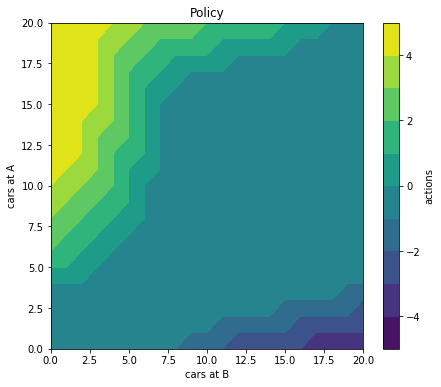

In [40]:
policy = np.argmax(q_sa,axis=1) - 5
plot_policy(policy)

Update 1, delta: 62.9995281477
Update 2, delta: 56.677752603
Update 3, delta: 50.8633152834
Update 4, delta: 45.4291613785
Update 5, delta: 40.4097735626
Update 6, delta: 35.8570095549
Update 7, delta: 31.7503699907
Update 8, delta: 28.0393290215
Update 9, delta: 24.6886659364
Update 10, delta: 21.6837528311
Update 11, delta: 19.016856382
Update 12, delta: 16.6748174251
Update 13, delta: 14.6351465165
Update 14, delta: 12.8671620276
Update 15, delta: 11.3361528953
Update 16, delta: 10.0106981742
Update 17, delta: 8.86061084391
Update 18, delta: 7.85955582489
Update 19, delta: 6.98569286952
Update 20, delta: 6.22051856486
Update 21, delta: 5.54846400767
Update 22, delta: 4.95638789096
Update 23, delta: 4.43359005469
Update 24, delta: 3.97017867818
Update 25, delta: 3.55836347522
Update 26, delta: 3.1916667849
Update 27, delta: 2.864578119
Update 28, delta: 2.57237704421
Update 29, delta: 2.31097694782
Update 30, delta: 2.07685849197
Update 31, delta: 1.86698259025
Update 32, delta: 1.67

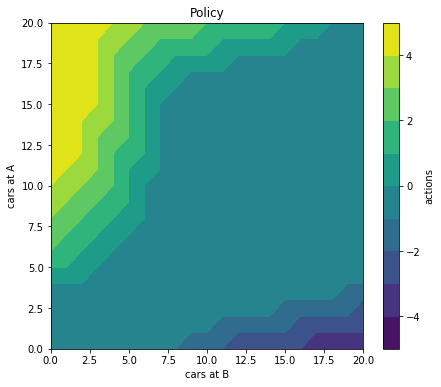

In [41]:
q_sa_2 = evaluate_policy(states, actions, get_probs)
policy_2 = np.argmax(q_sa_2,axis=1) - 5
plot_policy(policy_2)